# Cálculo de la frecuencia cradíaca a partir de la representación FFT

## 1. Importar los datos

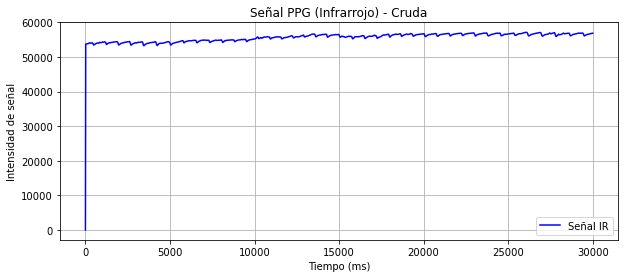

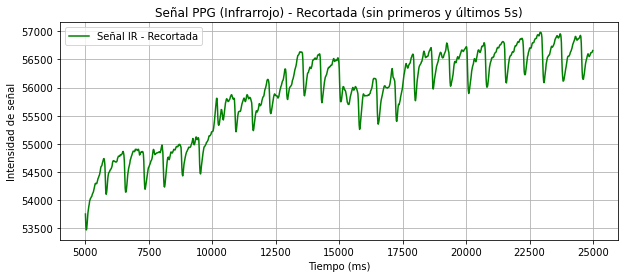

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# 1. Cargar los datos
file_path = file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path, sep=";")

# 2. Visualizar la señal PPG (IR)
plt.figure(figsize=(10, 4))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Cruda")
plt.legend()
plt.grid(True)
plt.show()

# Obtener el tiempo inicial y final
t_inicio = df["Tiempo (ms)"].iloc[0] + 5000  # +5 segundos
t_final = df["Tiempo (ms)"].iloc[-1] - 5000  # -5 segundos

# también se puede hacer así:
# # Recortar los primeros y últimos 5 segundos (300 muestras en cada extremo) --> 5s*60Hz
# df_recortado = df.iloc[300:-300].reset_index(drop=True)


# Filtrar el DataFrame
df_recortado = df[(df["Tiempo (ms)"] >= t_inicio) & (df["Tiempo (ms)"] <= t_final)].reset_index(drop=True)

# Visualizar la señal recortada
plt.figure(figsize=(10, 4))
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR"], label="Señal IR - Recortada", color="green")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Recortada (sin primeros y últimos 5s)")
plt.legend()
plt.grid(True)
plt.show()


## 2. Filtrar la señal

Ahora podemos aplicar un filtro paso bajo para eliminar el ruido de alta frecuencia. Como el pulso humano suele estar entre **0.5 Hz y 3 Hz**, filtraremos todo lo que esté por encima de 3 Hz.

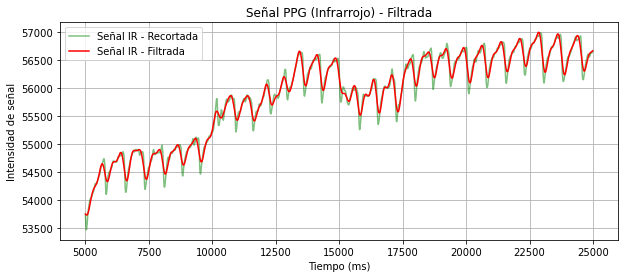

In [3]:
from scipy.signal import butter, filtfilt

# Función para aplicar filtro paso bajo
def butter_lowpass_filter(data, cutoff=3, fs=60, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Aplicar el filtro a la señal IR
df_recortado["IR_filtrada"] = butter_lowpass_filter(df_recortado["IR"])

# Visualizar la señal filtrada
plt.figure(figsize=(10, 4))
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR"], label="Señal IR - Recortada", color="green", alpha=0.5)
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR_filtrada"], label="Señal IR - Filtrada", color="red")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad de señal")
plt.title("Señal PPG (Infrarrojo) - Filtrada")
plt.legend()
plt.grid(True)
plt.show()


## 3. Representación FFT

La FFT nos ayudará a ver en qué frecuencia se concentra la mayor parte de la energía de la señal PPG. Si todo va bien, deberíamos ver un pico en la frecuencia del pulso (alrededor de 1-2 Hz para una persona en reposo).

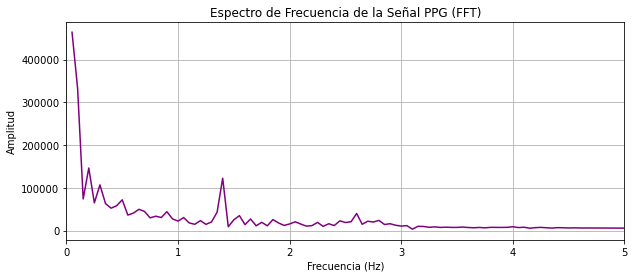

In [4]:
import numpy as np

# Obtener la señal y el tiempo
y = df_recortado["IR_filtrada"].values
t = df_recortado["Tiempo (ms)"].values / 1000  # Convertir ms a segundos

# Calcular la FFT
n = len(y)
frecuencia_muestreo = 60  # Hz
fft_y = np.fft.fft(y)
frecuencias = np.fft.fftfreq(n, d=1/frecuencia_muestreo)

# Tomar solo la parte positiva de la FFT
positivos = frecuencias > 0
frecuencias = frecuencias[positivos]
fft_y = np.abs(fft_y[positivos])

# Graficar la FFT
plt.figure(figsize=(10, 4))
plt.plot(frecuencias, fft_y, color="purple")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Espectro de Frecuencia de la Señal PPG (FFT)")
plt.grid(True)
plt.xlim(0, 5)  # Mostrar solo de 0 a 5 Hz (donde está el pulso)
plt.show()


## 4. Estimación de la frecuencia cardiaca

Ahora podemos estimar la frecuencia cardíaca a partir del pico más alto en la FFT. Como la frecuencia del pulso está en Hz, solo tenemos que convertirla a latidos por minuto (BPM).

In [5]:
# Encontrar el pico más alto en la FFT dentro del rango de interés (0.5 - 3 Hz)
rango_interes = (frecuencias >= 0.5) & (frecuencias <= 3)
frecuencias_interes = frecuencias[rango_interes]
fft_interes = fft_y[rango_interes]

# Obtener la frecuencia dominante
indice_pico = np.argmax(fft_interes)
frecuencia_pulso_hz = frecuencias_interes[indice_pico]

# Convertir a latidos por minuto (BPM)
frecuencia_pulso_bpm = frecuencia_pulso_hz * 60

print(f"Frecuencia cardíaca estimada: {frecuencia_pulso_bpm:.2f} BPM")


Frecuencia cardíaca estimada: 84.00 BPM


Archivo: raw_data_91_91.csv - Frecuencia cardíaca estimada: 35.94 BPM


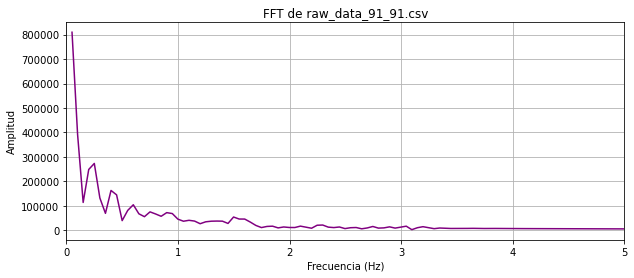

Archivo: raw_data_92_76.csv - Frecuencia cardíaca estimada: 83.86 BPM


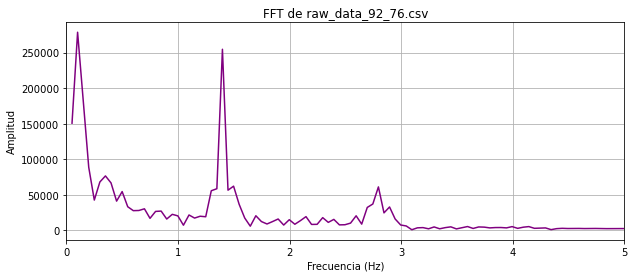

Archivo: raw_data_93_100.csv - Frecuencia cardíaca estimada: 32.95 BPM


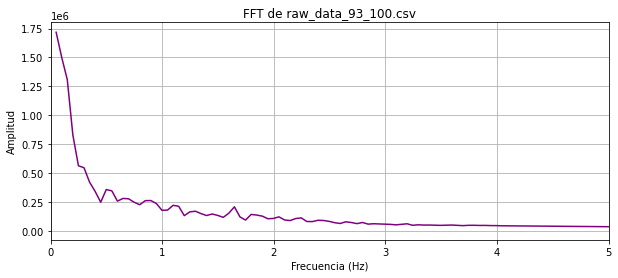

Archivo: raw_data_95_77_2.csv - Frecuencia cardíaca estimada: 83.86 BPM


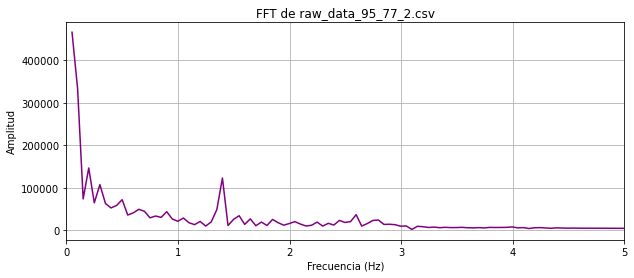

Archivo: raw_data_95_80.csv - Frecuencia cardíaca estimada: 74.88 BPM


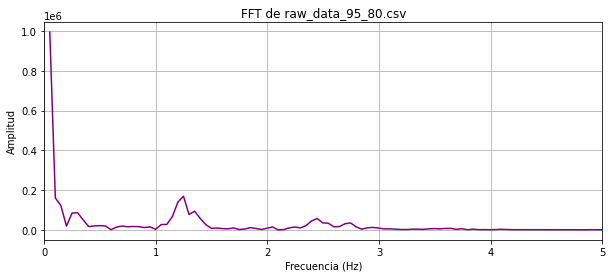

Archivo: raw_data_95_81_papa.csv - Frecuencia cardíaca estimada: 80.87 BPM


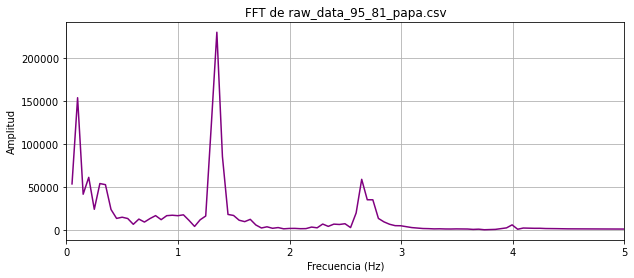

Archivo: raw_data_95_99.csv - Frecuencia cardíaca estimada: 98.84 BPM


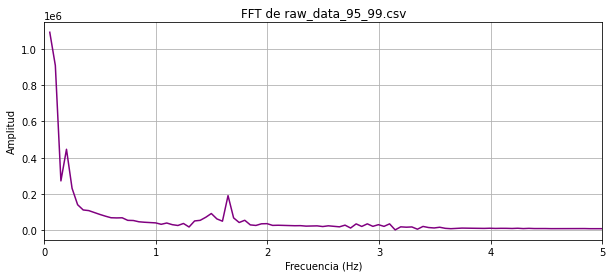

Archivo: raw_data_96_106.csv - Frecuencia cardíaca estimada: 35.94 BPM


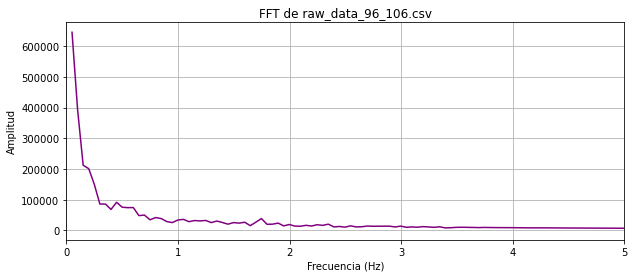

Archivo: raw_data_96_69.csv - Frecuencia cardíaca estimada: 71.88 BPM


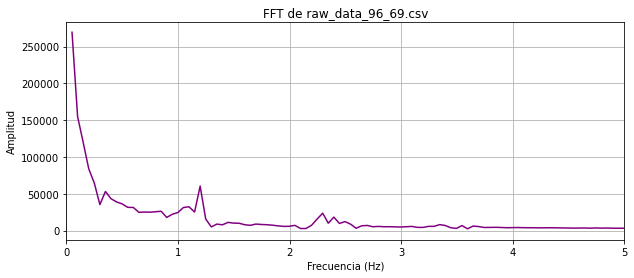

Archivo: raw_data_97_119.csv - Frecuencia cardíaca estimada: 32.95 BPM


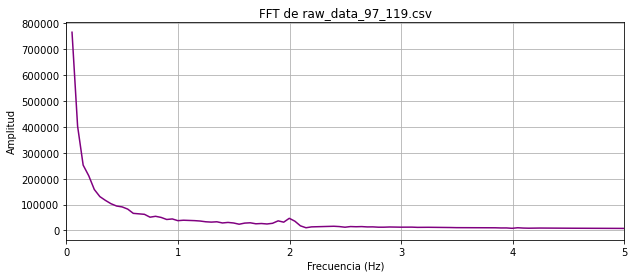

Archivo: raw_data_98_81.csv - Frecuencia cardíaca estimada: 80.87 BPM


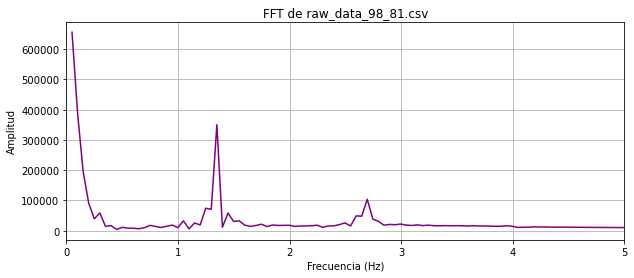

Archivo: raw_data_98_91.csv - Frecuencia cardíaca estimada: 101.83 BPM


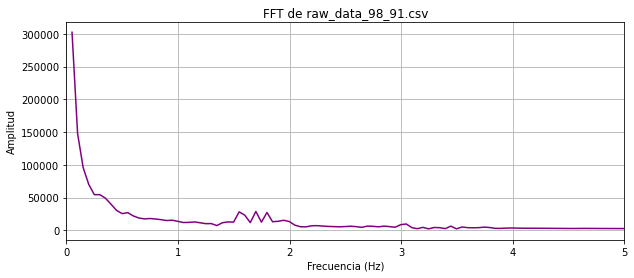

Archivo: raw_data_99_75.csv - Frecuencia cardíaca estimada: 74.88 BPM


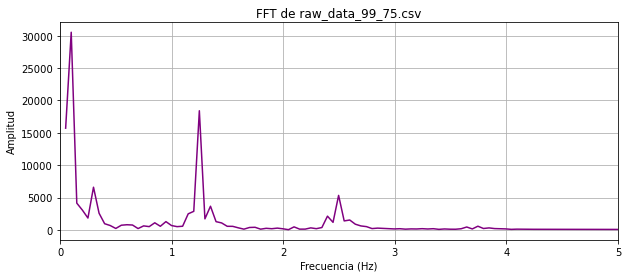

Archivo: raw_data_99_91.csv - Frecuencia cardíaca estimada: 35.94 BPM


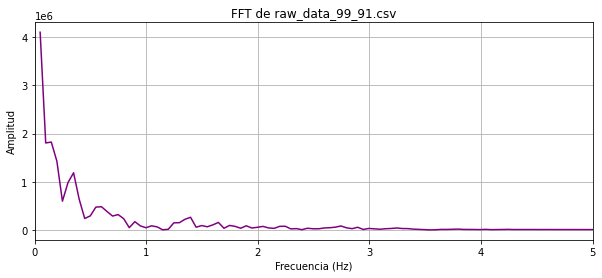

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Directorio donde están los archivos CSV
carpeta = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2"

# Parámetros generales
fs = 60  # Frecuencia de muestreo en Hz
t_recorte = 5  # Tiempo a recortar en segundos
n_muestras_recorte = t_recorte * fs  # Número de muestras a eliminar (5s * 60Hz)

# Función para aplicar filtro paso bajo
def butter_lowpass_filter(data, cutoff=3, fs=60, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Procesar cada archivo CSV en la carpeta
for archivo in os.listdir(carpeta):
    if archivo.endswith(".csv"):  # Solo archivos CSV
        file_path = os.path.join(carpeta, archivo)
        
        # Cargar los datos
        df = pd.read_csv(file_path, sep=";")

        # Verificar que tiene las columnas correctas
        if "Tiempo (ms)" not in df.columns or "IR" not in df.columns:
            print(f" {archivo} omitido: no tiene las columnas necesarias.")
            continue

        # Recortar los primeros y últimos 5 segundos
        df_recortado = df.iloc[n_muestras_recorte:-n_muestras_recorte].reset_index(drop=True)

        # Aplicar el filtro paso bajo
        df_recortado["IR_filtrada"] = butter_lowpass_filter(df_recortado["IR"])

        # Calcular la FFT
        y = df_recortado["IR_filtrada"].values
        n = len(y)
        fft_y = np.fft.fft(y)
        frecuencias = np.fft.fftfreq(n, d=1/fs)

        # Tomar solo la parte positiva de la FFT
        positivos = frecuencias > 0
        frecuencias = frecuencias[positivos]
        fft_y = np.abs(fft_y[positivos])

        # Encontrar el pico más alto en la FFT dentro del rango 0.5 - 3 Hz
        rango_interes = (frecuencias >= 0.5) & (frecuencias <= 3)
        if np.any(rango_interes):
            frecuencias_interes = frecuencias[rango_interes]
            fft_interes = fft_y[rango_interes]
            indice_pico = np.argmax(fft_interes)
            frecuencia_pulso_hz = frecuencias_interes[indice_pico]
            frecuencia_pulso_bpm = frecuencia_pulso_hz * 60
        else:
            frecuencia_pulso_bpm = np.nan  # No se encontró un pico válido

        # Imprimir la frecuencia cardíaca estimada
        print(f"Archivo: {archivo} - Frecuencia cardíaca estimada: {frecuencia_pulso_bpm:.2f} BPM")
        
        # Graficar FFT (opcional, si quieres ver la FFT de cada archivo)
        plt.figure(figsize=(10, 4))
        plt.plot(frecuencias, fft_y, color="purple")
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("Amplitud")
        plt.title(f"FFT de {archivo}")
        plt.xlim(0, 5)
        plt.grid(True)
        plt.show()